In [1]:
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.signal import lombscargle, savgol_filter
import pylab

In [2]:
# RV UMa: 1561928427003019520
# RZ Cep: 2211629018927324288
query = f"""
        SELECT *
        FROM gaiadr3.gaia_source
        WHERE has_epoch_photometry = 'True'
        AND source_id IN (1561928427003019520, 2211629018927324288)
        """
job = Gaia.launch_job_async(query)
results = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [56]:
retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'
datalink = Gaia.load_data(ids=results['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False)
dl_keys = [inp for inp in datalink.keys()] # Getting Epoch photometry keys for RV UMa & RZ Cep
dl_keys.sort()
RV_UMa_dl_key = dl_keys[0]
RZ_Cep_dl_key = dl_keys[1]
# Creating a readable table
RV_UMa_votable_data = datalink[RV_UMa_dl_key][0].to_table()
RZ_Cep_votable_data = datalink[RZ_Cep_dl_key][0].to_table()



In [57]:
RV_UMa_votable_data = RV_UMa_votable_data.to_pandas()
RV_UMa_votable_data = RV_UMa_votable_data.loc[~RV_UMa_votable_data.variability_flag_g_reject, :]
RV_UMa_votable_data = RV_UMa_votable_data.loc[~RV_UMa_votable_data.variability_flag_bp_reject, :]
RV_UMa_votable_data = RV_UMa_votable_data.loc[~RV_UMa_votable_data.variability_flag_rp_reject, :]
RV_UMa_votable_data = RV_UMa_votable_data.loc[~RV_UMa_votable_data.rejected_by_photometry, :]

RZ_Cep_votable_data = RZ_Cep_votable_data.to_pandas()
RZ_Cep_votable_data = RZ_Cep_votable_data.loc[~RZ_Cep_votable_data.variability_flag_g_reject, :]
RZ_Cep_votable_data = RZ_Cep_votable_data.loc[~RZ_Cep_votable_data.variability_flag_bp_reject, :]
RZ_Cep_votable_data = RZ_Cep_votable_data.loc[~RZ_Cep_votable_data.variability_flag_rp_reject, :]
RZ_Cep_votable_data = RZ_Cep_votable_data.loc[~RZ_Cep_votable_data.rejected_by_photometry, :]

In [4]:
# Gets observation times and magnitudes for each band for each star
def get_times_and_mags(time, flux, flux_err, votable_data):
    band_time  = np.array(votable_data[time])
    band_flux = np.array(votable_data[flux])
    band_flux_err = np.array(votable_data[flux_err])
    return (band_time, band_flux, band_flux_err)

In [58]:
RV_UMa_g_time, RV_UMa_g_flux, RV_UMa_g_flux_err = get_times_and_mags('g_transit_time', 'g_transit_flux', 'g_transit_flux_error', RV_UMa_votable_data)
RV_UMa_bp_time, RV_UMa_bp_flux, RV_UMa_bp_flux_err = get_times_and_mags('bp_obs_time', 'bp_flux', 'bp_flux_error', RV_UMa_votable_data)
RV_UMa_rp_time, RV_UMa_rp_flux, RV_UMa_rp_flux_err = get_times_and_mags('rp_obs_time', 'rp_flux', 'rp_flux_error', RV_UMa_votable_data)

In [44]:
RZ_Cep_g_time, RZ_Cep_g_flux, RZ_Cep_g_flux_err = get_times_and_mags('g_transit_time', 'g_transit_flux', 'g_transit_flux_error', RZ_Cep_votable_data)
RZ_Cep_bp_time, RZ_Cep_bp_flux, RZ_Cep_bp_flux_err = get_times_and_mags('bp_obs_time', 'bp_flux', 'bp_flux_error', RZ_Cep_votable_data)
RZ_Cep_rp_time, RZ_Cep_rp_flux, RZ_Cep_rp_flux_err = get_times_and_mags('rp_obs_time', 'rp_flux', 'bp_flux_error', RZ_Cep_votable_data)

In [13]:
def fold_lightcurve(time, mag, error, period):
    """
    Folds the lightcurve given a period.
    time: input time (same unit as period)
    mag: input magnitude
    error: input error
    period: period to be folded to, needs to same unit as time (i.e. days)
    returns: phase, folded magnitude, folded error
    """
    # Create a pandats dataframe from
    data = pd.DataFrame({"time": time, "flux": mag, "error": error})

    # create the phase
    data["phase"] = data.apply(lambda x: ((x.time / period) - np.floor(x.time / period)), axis=1)

    # Creates the out phase, flux and error
    phase_long = np.concatenate((data["phase"], data["phase"] + 1.0))
    mag_long = np.concatenate((mag, mag))
    err_long = np.concatenate((error, error))

    phase_sort = np.argsort(phase_long)
    phase_long_sorted = phase_long[phase_sort]
    mag_long_sorted = mag_long[phase_sort]
    err_long_sorted = err_long[phase_sort]

    nanmask = ~np.isnan(phase_long_sorted) & ~np.isnan(mag_long_sorted) & ~np.isnan(err_long_sorted)
    
    return (phase_long_sorted[nanmask], mag_long_sorted[nanmask], err_long_sorted[nanmask])

In [59]:
RV_UMa_period = 0.46805905525592434 # From GAIA DR3
RV_UMa_g_phase, RV_UMa_g_phase_flux, RV_UMa_g_phase_err = fold_lightcurve(RV_UMa_g_time, RV_UMa_g_flux, RV_UMa_g_flux_err, RV_UMa_period)
RV_UMa_bp_phase, RV_UMa_bp_phase_flux, RV_UMa_bp_phase_err = fold_lightcurve(RV_UMa_bp_time, RV_UMa_bp_flux, RV_UMa_bp_flux_err, RV_UMa_period)
RV_UMa_rp_phase, RV_UMa_rp_phase_flux, RV_UMa_rp_phase_err = fold_lightcurve(RV_UMa_rp_time, RV_UMa_rp_flux, RV_UMa_rp_flux_err, RV_UMa_period)

In [46]:
RZ_Cep_period = 0.308704 # From SIMBAD
RZ_Cep_g_phase, RZ_Cep_g_phase_flux, RZ_Cep_g_phase_err = fold_lightcurve(RZ_Cep_g_time, RZ_Cep_g_flux, RZ_Cep_g_flux_err, RZ_Cep_period)
RZ_Cep_bp_phase, RZ_Cep_bp_phase_flux, RZ_Cep_bp_phase_err = fold_lightcurve(RZ_Cep_bp_time, RZ_Cep_bp_flux, RZ_Cep_bp_flux_err, RZ_Cep_period)
RZ_Cep_rp_phase, RZ_Cep_rp_phase_flux, RZ_Cep_rp_phase_err = fold_lightcurve(RZ_Cep_rp_time, RZ_Cep_rp_flux, RZ_Cep_rp_flux_err, RZ_Cep_period)

In [60]:
zeropoint_arr = np.loadtxt('GaiaEDR3_passbands_zeropoints_version2/zeropt.dat', dtype='str')
G_band_zp = float(zeropoint_arr[0][0])
G_band_zp_unc = float(zeropoint_arr[0][1])
BP_band_zp = float(zeropoint_arr[0][2])
BP_band_zp_unc = float(zeropoint_arr[0][3])
RP_band_zp = float(zeropoint_arr[0][4])
RP_band_zp_unc = float(zeropoint_arr[0][5])


In [17]:
def flux_to_mag(flux_array, zeropoint):
    mag_array = -2.5 * np.log10(flux_array) + zeropoint
    return mag_array

In [18]:
def mag_error(flux_array, flux_err_array, zeropoint, zeropoint_err):
    mag_err_array = []
    dM_dF = - 5 / (2 * np.log(10) * flux_array)
    dM_dZ = 1
    mag_err = np.sqrt(np.square(dM_dF * flux_err_array) + np.square(dM_dZ * zeropoint_err))
    return mag_err

In [61]:
RV_UMa_g_phase_mag = flux_to_mag(RV_UMa_g_phase_flux, G_band_zp)
RV_UMa_bp_phase_mag = flux_to_mag(RV_UMa_bp_phase_flux, BP_band_zp)
RV_UMa_rp_phase_mag = flux_to_mag(RV_UMa_rp_phase_flux, RP_band_zp)

In [62]:
RV_UMa_g_phase_mag_err = mag_error(RV_UMa_g_phase_flux, RV_UMa_g_phase_err, G_band_zp, G_band_zp_unc)
RV_UMa_bp_phase_mag_err = mag_error(RV_UMa_bp_phase_flux, RV_UMa_bp_phase_err, BP_band_zp, BP_band_zp_unc)
RV_UMa_rp_phase_mag_err = mag_error(RV_UMa_rp_phase_flux, RV_UMa_rp_phase_err, RP_band_zp, RP_band_zp_unc)

In [50]:
RZ_Cep_g_phase_mag = flux_to_mag(RZ_Cep_g_phase_flux, G_band_zp)
RZ_Cep_bp_phase_mag = flux_to_mag(RZ_Cep_bp_phase_flux, BP_band_zp)
RZ_Cep_rp_phase_mag = flux_to_mag(RZ_Cep_rp_phase_flux, RP_band_zp)
#1.0857*(RZ_Cep_g_phase_err/RZ_Cep_g_phase_flux)

In [52]:
RZ_Cep_g_phase_mag_err = mag_error(RZ_Cep_g_phase_flux, RZ_Cep_g_phase_err, G_band_zp, G_band_zp_unc)
RZ_Cep_bp_phase_mag_err = mag_error(RZ_Cep_bp_phase_flux, RZ_Cep_bp_phase_err, BP_band_zp, BP_band_zp_unc)
RZ_Cep_rp_phase_mag_err = mag_error(RZ_Cep_rp_phase_flux, RZ_Cep_rp_phase_err, RP_band_zp, RP_band_zp_unc)

In [23]:
def sine_function(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

In [24]:
def sin_fit(phase, phase_mag, initial_guess):
    popt, pcov = curve_fit(sine_function, phase, phase_mag, p0=initial_guess)
    A_fit, B_fit, C_fit, D_fit = popt
    print(f"Fitted parameters: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit}")
    y_fit = sine_function(phase, A_fit, B_fit, C_fit, D_fit)
    return y_fit


In [25]:
z = np.polyfit(RV_UMa_g_phase, RV_UMa_g_phase_mag, 18)
f = np.poly1d(z)

x_new = np.linspace(RV_UMa_g_phase[0], RV_UMa_g_phase[-1], 100)
y_new = f(x_new)



In [26]:
for i in range(len(x_new)-1):
    (np.absolute(y_new[i+1]-y_new[i] / x_new[i+1]-x_new[i]))

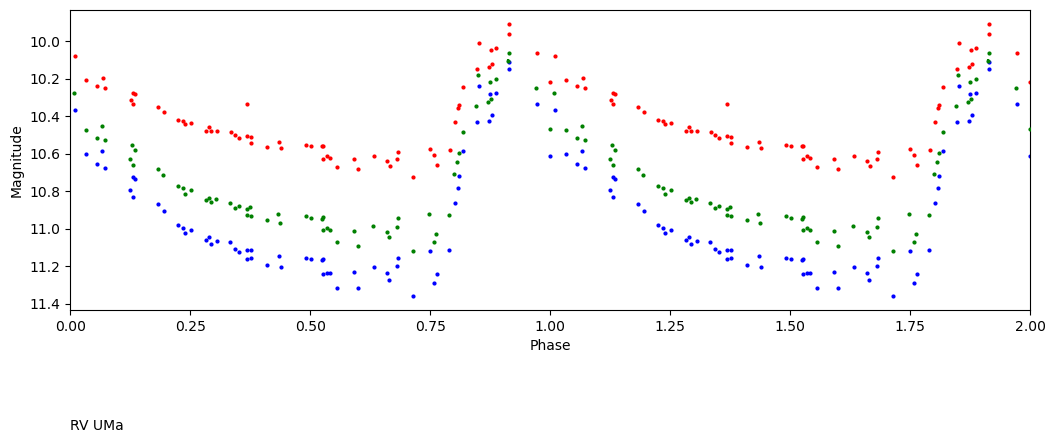

In [63]:
fig2_text = "RV UMa"

fig2 = plt.figure(figsize=(12,6))
ax2 = fig2.add_axes((.1,.4,.8,.5))
ax2.errorbar(RV_UMa_g_phase, RV_UMa_g_phase_mag, yerr=RV_UMa_g_phase_mag_err, marker='o', ms=2, ls='None', zorder=3, c='Green')
ax2.errorbar(RV_UMa_bp_phase, RV_UMa_bp_phase_mag, yerr=RV_UMa_bp_phase_mag_err, marker='o', ms=2, ls='None', zorder=2, c='Blue')
ax2.errorbar(RV_UMa_rp_phase, RV_UMa_rp_phase_mag, yerr=RV_UMa_rp_phase_mag_err, marker='o', ms=2, ls='None', zorder=1, c='Red')
#plt.plot(x_new, y_new, color='Black')

ax2.set_xlabel("Phase")
ax2.set_ylabel("Magnitude")
ax2.yaxis.set_inverted(True)
fig2.text(.1,.2,fig2_text)
plt.xlim([0,2])
plt.show()

In [28]:
#phase_sort = np.argsort(RZ_Cep_g_phase)
#RZ_Cep_g_phase_sorted = RZ_Cep_g_phase[phase_sort]
#RZ_Cep_g_phase_mag_sorted = RZ_Cep_g_phase_mag[phase_sort]
#RZ_Cep_g_phase_mag_err_sorted = RZ_Cep_g_phase_mag_err[phase_sort]

In [53]:
initial_guess_RZ_Cep = [0.2, 2*np.pi, 3.3, 9.2]

y_fit_g = sin_fit(RZ_Cep_g_phase, RZ_Cep_g_phase_mag, initial_guess_RZ_Cep)
y_fit_bp = sin_fit(RZ_Cep_bp_phase, RZ_Cep_bp_phase_mag, initial_guess_RZ_Cep)
y_fit_rp = sin_fit(RZ_Cep_rp_phase, RZ_Cep_rp_phase_mag, initial_guess_RZ_Cep)

Fitted parameters: A=-0.24672228104118737, B=6.396207886298666, C=2.5101659178823743, D=9.281004633307395
Fitted parameters: A=-0.2995706810370314, B=6.389602706958406, C=2.532170921586049, D=9.5701648784739
Fitted parameters: A=-0.18346869117860043, B=6.415234378407965, C=2.456053484598498, D=8.81126280009456


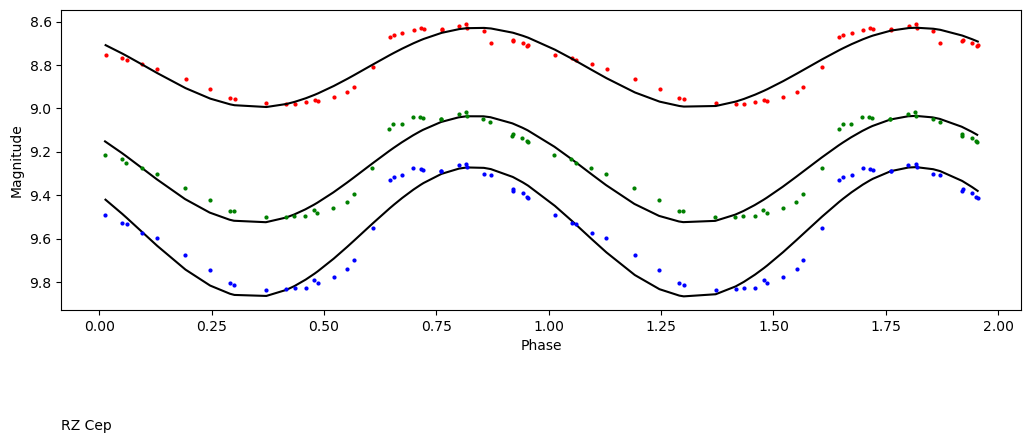

In [54]:


fig3_text = "RZ Cep"

fig3 = plt.figure(figsize=(12,6))
ax3 = fig3.add_axes((.1,.4,.8,.5))
ax3.errorbar(RZ_Cep_g_phase, RZ_Cep_g_phase_mag, yerr=RZ_Cep_g_phase_mag_err, marker='o', ms=2, ls='None', zorder=3, c='Green')
ax3.errorbar(RZ_Cep_bp_phase, RZ_Cep_bp_phase_mag, yerr=RZ_Cep_bp_phase_mag_err, marker='o', ms=2, ls='None', zorder=2, c='Blue')
ax3.errorbar(RZ_Cep_rp_phase, RZ_Cep_rp_phase_mag, yerr=RZ_Cep_rp_phase_mag_err, marker='o', ms=2, ls='None', zorder=1, c='Red')
plt.plot(RZ_Cep_g_phase, y_fit_g, label='Fitted Curve', color='black')
plt.plot(RZ_Cep_bp_phase, y_fit_bp, label='Fitted Curve', color='black')
plt.plot(RZ_Cep_rp_phase, y_fit_rp, label='Fitted Curve', color='black')

ax3.set_xlabel("Phase")
ax3.set_ylabel("Magnitude")
ax3.yaxis.set_inverted(True)
fig3.text(.1,.2,fig3_text)
plt.show()